### Importing libriaries

In [51]:
import networkx as nx
import re
import tqdm
import collections
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import copy
import csv
from itertools import combinations
from scipy.cluster.hierarchy import fcluster
from collections import Counter 
import igraph as ig
from networkx.algorithms import community as nx_community

## COMMUNITIES

In [155]:
G = nx.read_graphml('undirected.graphml')

Modularity of the network: 0.005888228664130157


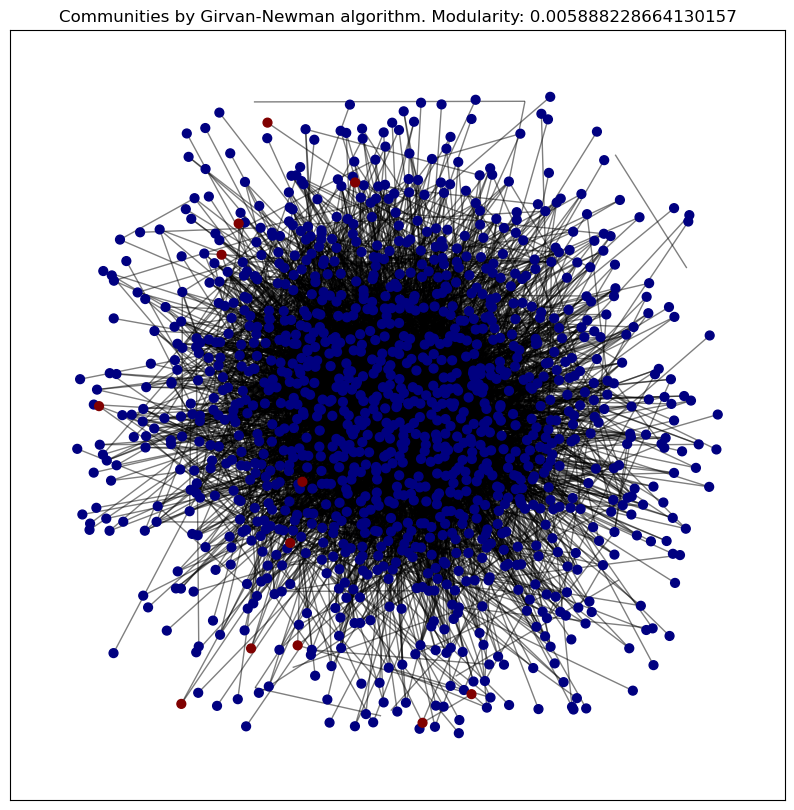

Number of communities after filtering: 2
Community 0: Size 1237
Community 23: Size 12


In [191]:
# Girvan-Newman algorithm
communities_generator = nx_community.girvan_newman(G)

num_levels = 4 
for _ in range(num_levels):
    next_level_communities = next(communities_generator)

partition = {node: cid for cid, community in enumerate(next_level_communities) for node in community}

# calculate and print modularity with the current level of partition
modularity = nx_community.modularity(G, next_level_communities)
print(f"Modularity of the network: {modularity}")

# count the sizes of each community
community_sizes = Counter(partition.values())

# filter out communities with 1 or 2 nodes only for visualization purposes
filtered_partition = {node: community for node, community in partition.items() if community_sizes[community] > 2}

# visualize the graph without small communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)
cmap = plt.cm.jet

nx.draw_networkx_nodes(G, pos, filtered_partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(filtered_partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Communities by Girvan-Newman algorithm. Modularity: {modularity}")
plt.savefig('community_girvan_newman.jpg', format='jpg')
plt.show()
# print information about communities after filtering
filtered_community_sizes = Counter(filtered_partition.values())
print("Number of communities after filtering:", len(filtered_community_sizes))
for community, size in filtered_community_sizes.items():
    print(f"Community {community}: Size {size}")


Modularity of the network: 0.39858521149410825


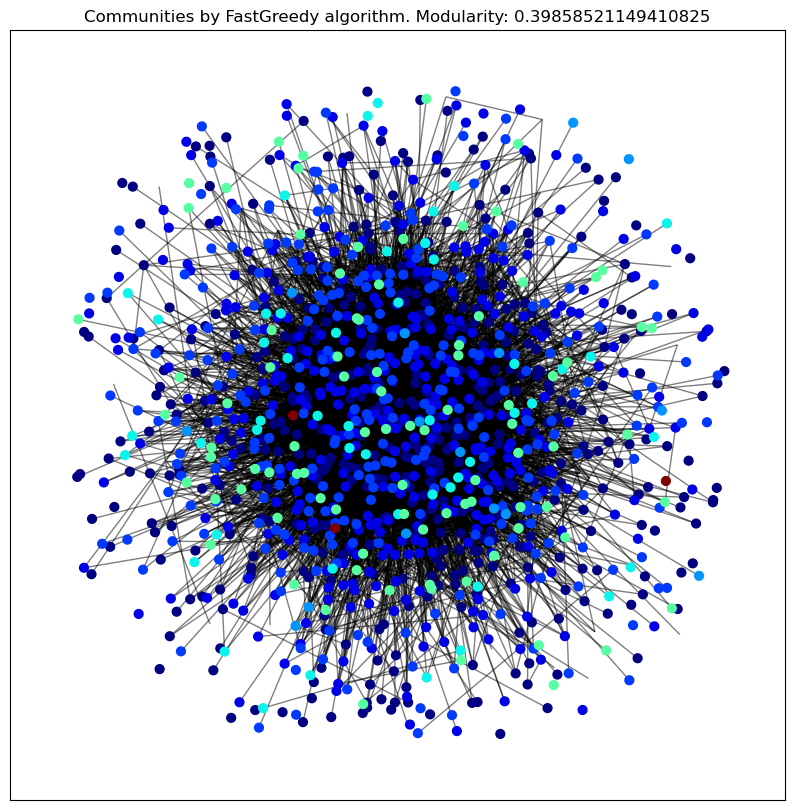

Community 0: Size 460, Strength: 0.01, Central Node: Hip hop music
Community 1: Size 355, Strength: 0.01, Central Node: Punk rock
Community 2: Size 277, Strength: 0.01, Central Node: Country music
Community 3: Size 15, Strength: 0.00, Central Node: Nu-disco
Community 4: Size 49, Strength: 0.00, Central Node: New-age music
Community 5: Size 88, Strength: 0.01, Central Node: Contemporary R&B
Community 11: Size 3, Strength: 0.00, Central Node: Cuban rumba


In [189]:
# FastGreedy community
g = ig.Graph.TupleList(G.edges(), directed=False)
index_to_label = {index: label for index, label in enumerate(nxG.nodes())}

dendrogram = g.community_fastgreedy()
clusters = dendrogram.as_clustering()
partition = {index_to_label[index]: cid for cid, community in enumerate(clusters) for index in community}

# calculate modularity 
modularity = clusters.modularity
print(f"Modularity of the network: {modularity}")

# count the sizes of each community
community_sizes = Counter(partition.values())

# calculate community strength and central node for each community
community_strength = {}
central_nodes = {}

for community in set(partition.values()):
    subgraph_nodes = [node for node, comm in partition.items() if comm == community]
    subgraph = nxG.subgraph(subgraph_nodes)
    internal_edges = subgraph.number_of_edges()
    possible_edges = len(subgraph) * (len(subgraph) - 1) / 2
    community_strength[community] = internal_edges / possible_edges if possible_edges > 0 else 0

    degree_centrality = nx.degree_centrality(subgraph)
    central_node = max(degree_centrality, key=degree_centrality.get)
    central_nodes[community] = central_node

# filter out communities with 1 or 2 nodes only for visualization purposes
filtered_partition = {node: community for node, community in partition.items() if community_sizes[community] > 2}

# visualize the graph without small communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nxG, k=0.15, iterations=20)
cmap = plt.cm.jet

# use correct node labels for plotting
nx.draw_networkx_nodes(nxG, pos, nodelist=filtered_partition.keys(), node_size=40,
                       cmap=cmap, node_color=[filtered_partition[node] for node in filtered_partition.keys()])
nx.draw_networkx_edges(nxG, pos, alpha=0.5)
plt.title(f"Communities by FastGreedy algorithm. Modularity: {modularity}")
plt.savefig('community_fastgreedy.jpg', format='jpg')
plt.show()

# print information for each community
for community in set(filtered_partition.values()):
    size = community_sizes[community]
    strength = community_strength[community]
    central_node = central_nodes[community]

    print(f"Community {community}: Size {size}, Strength: {strength:.2f}, Central Node: {central_node}")


Modularity of the network: 0.4653784746868097


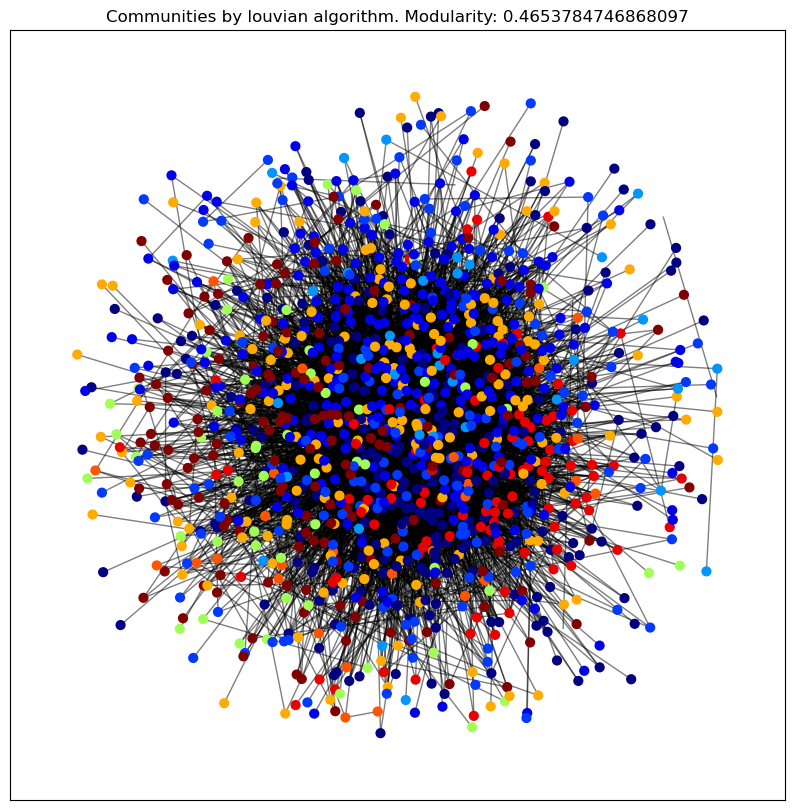

Number of communities after filtering: 9
Community 1: Size 264, Strength: 0.03, Central Node: List of electronic music genres
Community 2: Size 273, Strength: 0.03, Central Node: List of rock genres
Community 3: Size 164, Strength: 0.03, Central Node: Arabic music
Community 4: Size 34, Strength: 0.14, Central Node: K-pop
Community 7: Size 54, Strength: 0.07, Central Node: List of jazz genres
Community 9: Size 175, Strength: 0.04, Central Node: List of styles of music: A–F
Community 10: Size 28, Strength: 0.13, Central Node: Beautiful music
Community 11: Size 100, Strength: 0.08, Central Node: List of hip hop genres
Community 12: Size 163, Strength: 0.03, Central Node: List of styles of music: G–M


In [187]:
# louvain - communities
partition = community_louvain.best_partition(G)

# calculate modularity
modularity = community_louvain.modularity(partition, G)
print(f"Modularity of the network: {modularity}")

# sizes of each community
community_sizes = Counter(partition.values())

# calculate community strength and central node for each community
community_strength = {}
central_nodes = {}

for community in set(partition.values()):
    subgraph = G.subgraph([node for node, comm in partition.items() if comm == community])
    internal_edges = subgraph.number_of_edges()
    possible_edges = len(subgraph) * (len(subgraph) - 1) / 2
    community_strength[community] = internal_edges / possible_edges if possible_edges > 0 else 0

    # Degree centrality for central node
    degree_centrality = nx.degree_centrality(subgraph)
    central_node = max(degree_centrality, key=degree_centrality.get)
    central_nodes[community] = central_node

# filter out communities with 1 or 2 nodes only for visualization purposes
filtered_partition = {node: community for node, community in partition.items() if community_sizes[community] > 2}

# visualize the graph without small communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)
cmap = plt.cm.jet

nx.draw_networkx_nodes(G, pos, filtered_partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(filtered_partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Communities by louvian algorithm. Modularity: {modularity}")
plt.savefig('community_louvian.jpg', format='jpg')
plt.show()

filtered_community_sizes = Counter(filtered_partition.values())
print("Number of communities after filtering:", len(filtered_community_sizes))

# print information for each community
for community in set(filtered_partition.values()):
    size = community_sizes[community]
    strength = community_strength[community]
    central_node = central_nodes[community]

    print(f"Community {community}: Size {size}, Strength: {strength:.2f}, Central Node: {central_node}")


## hierarchical clustering

Number of all clusters identified: 1034 - distance_threshold: 2.0
Number of clusters identified (excluding single-node and double-node clusters): 18
Cluster 712: Number of vertices: 174, Central node: Gospel blues
Cluster 688: Number of vertices: 3, Central node: Ars subtilior
Cluster 693: Number of vertices: 4, Central node: Galant music
Cluster 690: Number of vertices: 6, Central node: Classic female blues
Cluster 698: Number of vertices: 4, Central node: Desert blues
Cluster 699: Number of vertices: 7, Central node: St. Louis blues (music)
Cluster 689: Number of vertices: 5, Central node: Acousmatic music
Cluster 697: Number of vertices: 35, Central node: Kawaii future bass
Cluster 694: Number of vertices: 4, Central node: Hardstep
Cluster 636: Number of vertices: 3, Central node: Rabòday
Cluster 651: Number of vertices: 5, Central node: Freestyle rap
Cluster 700: Number of vertices: 3, Central node: Desert rock
Cluster 439: Number of vertices: 3, Central node: Fuji music
Cluster 58

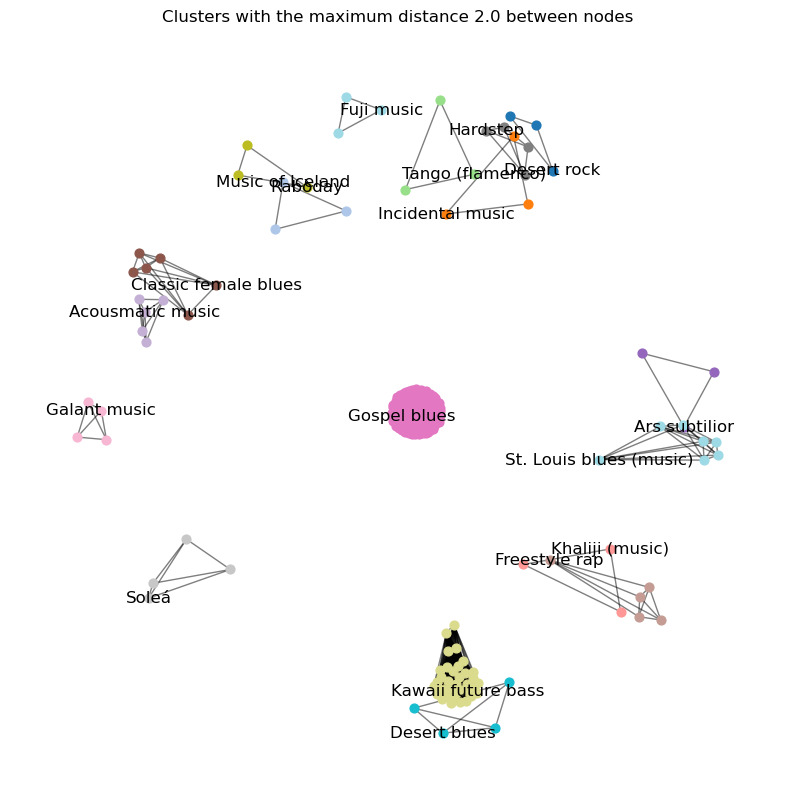

In [161]:
# hierarchical clustering to assign clusters
distance_threshold = 2.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")

# calculate layout for the visualization graph with increased edge length
pos = nx.spring_layout(visG, k=0.25)

# draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(visG, pos, alpha=0.5)

# draw nodes with different colors for each cluster in the visualization graph
palette = plt.cm.tab20.colors 
for cluster_id in set(cluster_dict.values()):
    nx.draw_networkx_nodes(
        visG, pos,
        nodelist=[node for node, cluster in cluster_dict.items() if cluster == cluster_id],
        node_size=40,
        node_color=[palette[cluster_id % len(palette)]]
    )

# label the central nodes
central_node_labels = {node: node for node in important_nodes.values()}
nx.draw_networkx_labels(visG, pos, labels=central_node_labels, font_color='black')

plt.title(f"Clusters with the maximum distance {distance_threshold} between nodes")
plt.axis('off')
plt.savefig('clusters_visualization.jpg', format='jpg')
plt.show()



# save the cluster information and positions to CSV files
with open('clusters.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'cluster']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, cluster in cluster_dict.items():
        writer.writerow({'node': node, 'cluster': cluster})

with open('clusters_positions.csv', 'w', newline='') as csvfile:
    fieldnames = ['node', 'pos_x', 'pos_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for node, position in pos.items():
        writer.writerow({'node': node, 'pos_x': position[0], 'pos_y': position[1]})


Number of all clusters identified: 684 - distance_threshold: 3.0
Number of clusters identified (excluding single-node and double-node clusters): 35
Cluster 408: Number of vertices: 508, Central node: Post-grunge
Cluster 389: Number of vertices: 3, Central node: Electroacoustic music
Cluster 358: Number of vertices: 3, Central node: Lowercase (music)
Cluster 278: Number of vertices: 4, Central node: Swamp rock
Cluster 397: Number of vertices: 3, Central node: Texas blues
Cluster 347: Number of vertices: 3, Central node: Background music
Cluster 367: Number of vertices: 3, Central node: Hipster hop
Cluster 332: Number of vertices: 3, Central node: Frenchcore
Cluster 383: Number of vertices: 4, Central node: Acid trance
Cluster 379: Number of vertices: 3, Central node: Lofi hip hop
Cluster 359: Number of vertices: 3, Central node: Diva house
Cluster 351: Number of vertices: 3, Central node: Latin house
Cluster 384: Number of vertices: 4, Central node: Dream trance
Cluster 175: Number of v

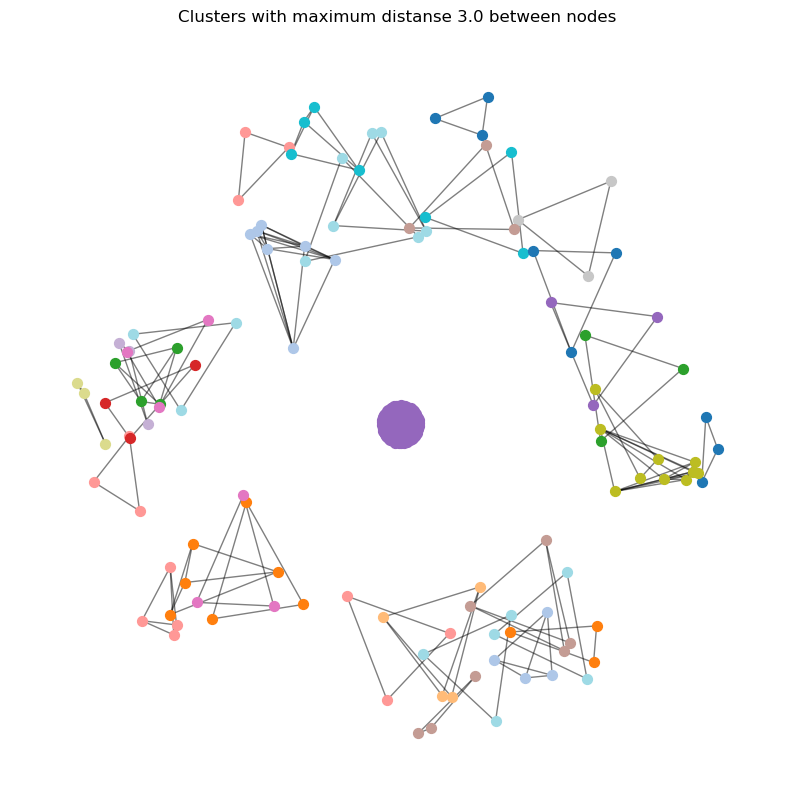

In [152]:
# hierarchical clustering to assign clusters
distance_threshold = 3.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# Count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")

pos = nx.spring_layout(visG, k=0.2)

# draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(visG, pos, alpha=0.5)

# draw nodes with different colors for each cluster in the visualization graph
palette = plt.cm.tab20.colors 
for cluster_id in set(cluster_dict.values()):
    nx.draw_networkx_nodes(
        visG, pos,
        nodelist=[node for node, cluster in cluster_dict.items() if cluster == cluster_id],
        node_size=50,
        node_color=[palette[cluster_id % len(palette)]]
    )

# Comment out or remove the following line to stop drawing labels
# nx.draw_networkx_labels(visG, pos, labels=central_node_labels, font_color='black')

plt.title(f"Clusters with maximum distanse {distance_threshold} between nodes")
plt.axis('off')
plt.savefig('clusters_thres_3.jpg', format='jpg')
plt.show()

In [147]:
# hierarchical clustering to assign clusters
distance_threshold = 5.0
clusters = fcluster(Z, distance_threshold, criterion='distance')

# all clusters
all_clusters = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster)}

# assign clusters to nodes, skipping clusters with only one and two nodes
cluster_dict = {node: cluster for node, cluster in zip(G.nodes(), clusters) if list(clusters).count(cluster) > 2}

# create a new graph for visualization
visG = nx.Graph()

# add edges to make sure all nodes in each cluster are connected
for cluster in set(cluster_dict.values()):
    nodes_in_cluster = [node for node, clust in cluster_dict.items() if clust == cluster]
    for node1, node2 in combinations(nodes_in_cluster, 2):
        visG.add_edge(node1, node2)

# calculate degree centrality for each node in the original graph
degree_centrality = nx.degree_centrality(G)

# find the most important node in each cluster of the original graph
important_nodes = {}
for node, cluster in cluster_dict.items():
    if cluster not in important_nodes:
        important_nodes[cluster] = node
    elif degree_centrality[node] > degree_centrality[important_nodes[cluster]]:
        important_nodes[cluster] = node

# count the number of vertices in each cluster
cluster_counts = Counter(cluster_dict.values())

# print the most important nodes for each cluster
num_clusters = len(set(all_clusters.values()))
print(f"Number of all clusters identified: {num_clusters} - distance_threshold: {distance_threshold}")
num_clusters = len(set(cluster_dict.values()))
print(f"Number of clusters identified (excluding single-node and double-node clusters): {num_clusters}")
for cluster, node in important_nodes.items():
    print(f"Cluster {cluster}: Number of vertices: {cluster_counts[cluster]}, Central node: {node}")



Number of all clusters identified: 167 - distance_threshold: 5.0
Number of clusters identified (excluding single-node and double-node clusters): 3
Cluster 29: Number of vertices: 1163, Central node: Americana (music)
Cluster 28: Number of vertices: 3, Central node: Electronicore
Cluster 20: Number of vertices: 5, Central node: Southern hip hop
